In [3]:
# Import necessary libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import numpy as np

In [4]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [5]:
# Define paths
base_path = r"dataset\train"  # Use raw string and fix separator
csv_path = os.path.join(base_path, "train_data.csv")

# Load the CSV file
df = pd.read_csv(r"C:\Users\sunhe\DS Projects\diseaseIdentifyByChickShit\dataset\train_data.csv")

# Display basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check class distribution
print("\nClass Distribution:")
print(df['label'].value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8067 entries, 0 to 8066
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  8067 non-null   object
 1   label   8067 non-null   object
dtypes: object(2)
memory usage: 126.2+ KB
None

First 5 rows:
           images               label
0  salmo.1558.jpg          Salmonella
1  cocci.1866.jpg         Coccidiosis
2   cocci.171.jpg         Coccidiosis
3  salmo.1484.jpg          Salmonella
4     ncd.100.jpg  New Castle Disease

Missing Values:
images    0
label     0
dtype: int64

Class Distribution:
Salmonella            2625
Coccidiosis           2476
Healthy               2404
New Castle Disease     562
Name: label, dtype: int64


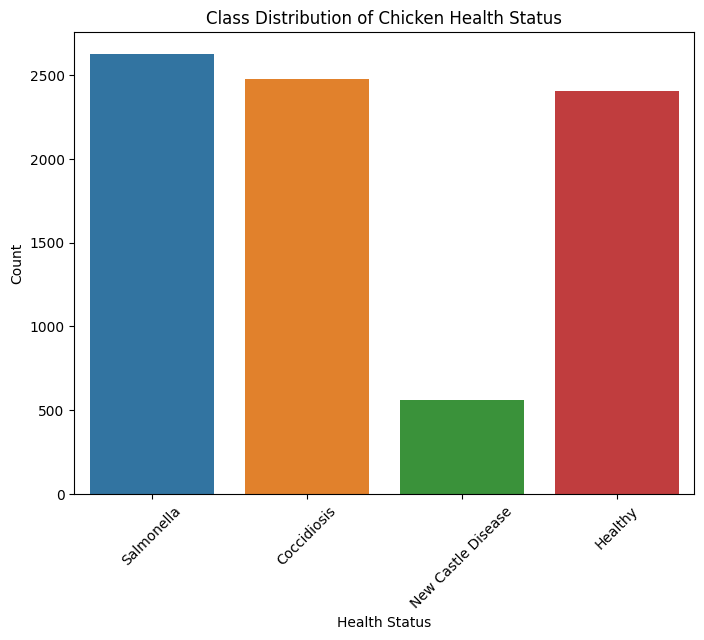

In [6]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title("Class Distribution of Chicken Health Status")
plt.xlabel("Health Status")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

All images are accessible and can be loaded.

Image Size Statistics:
        width  height
count  8067.0  8067.0
mean    224.0   224.0
std       0.0     0.0
min     224.0   224.0
25%     224.0   224.0
50%     224.0   224.0
75%     224.0   224.0
max     224.0   224.0


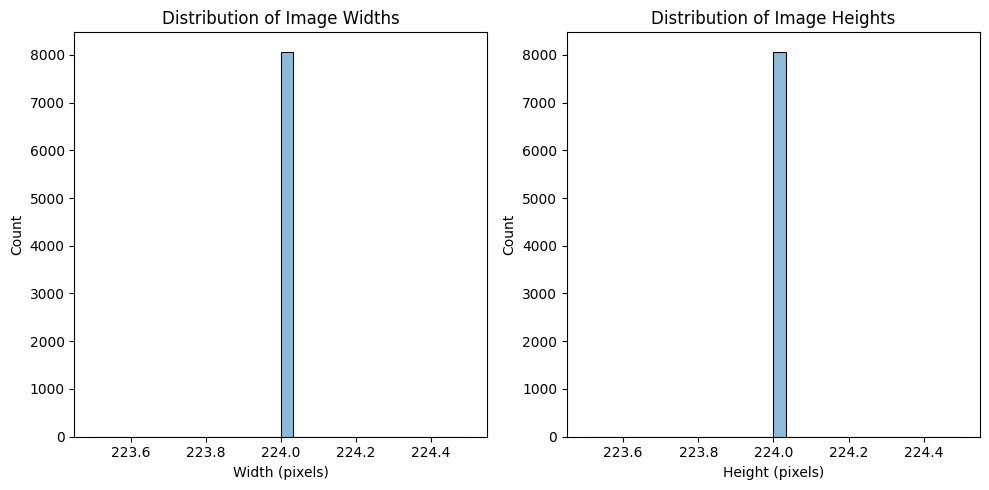

In [7]:
# Verify that all images exist and can be loaded
missing_images = []
image_sizes = []

for img_name in df['images']:
    img_path = os.path.join(base_path, img_name)
    if not os.path.exists(img_path):
        missing_images.append(img_name)
    else:
        # Load image to check if it can be opened and get its size
        try:
            img = Image.open(img_path)
            image_sizes.append(img.size)  # (width, height)
        except Exception as e:
            missing_images.append(img_name)
            print(f"Error loading {img_name}: {e}")

# Report missing or corrupted images
if missing_images:
    print(f"Found {len(missing_images)} missing or corrupted images:")
    print(missing_images)
else:
    print("All images are accessible and can be loaded.")

# Analyze image sizes
image_sizes_df = pd.DataFrame(image_sizes, columns=['width', 'height'])
print("\nImage Size Statistics:")
print(image_sizes_df.describe())

# Visualize image size distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(image_sizes_df['width'], bins=30, kde=True)
plt.title("Distribution of Image Widths")
plt.xlabel("Width (pixels)")

plt.subplot(1, 2, 2)
sns.histplot(image_sizes_df['height'], bins=30, kde=True)
plt.title("Distribution of Image Heights")
plt.xlabel("Height (pixels)")
plt.tight_layout()
plt.show()

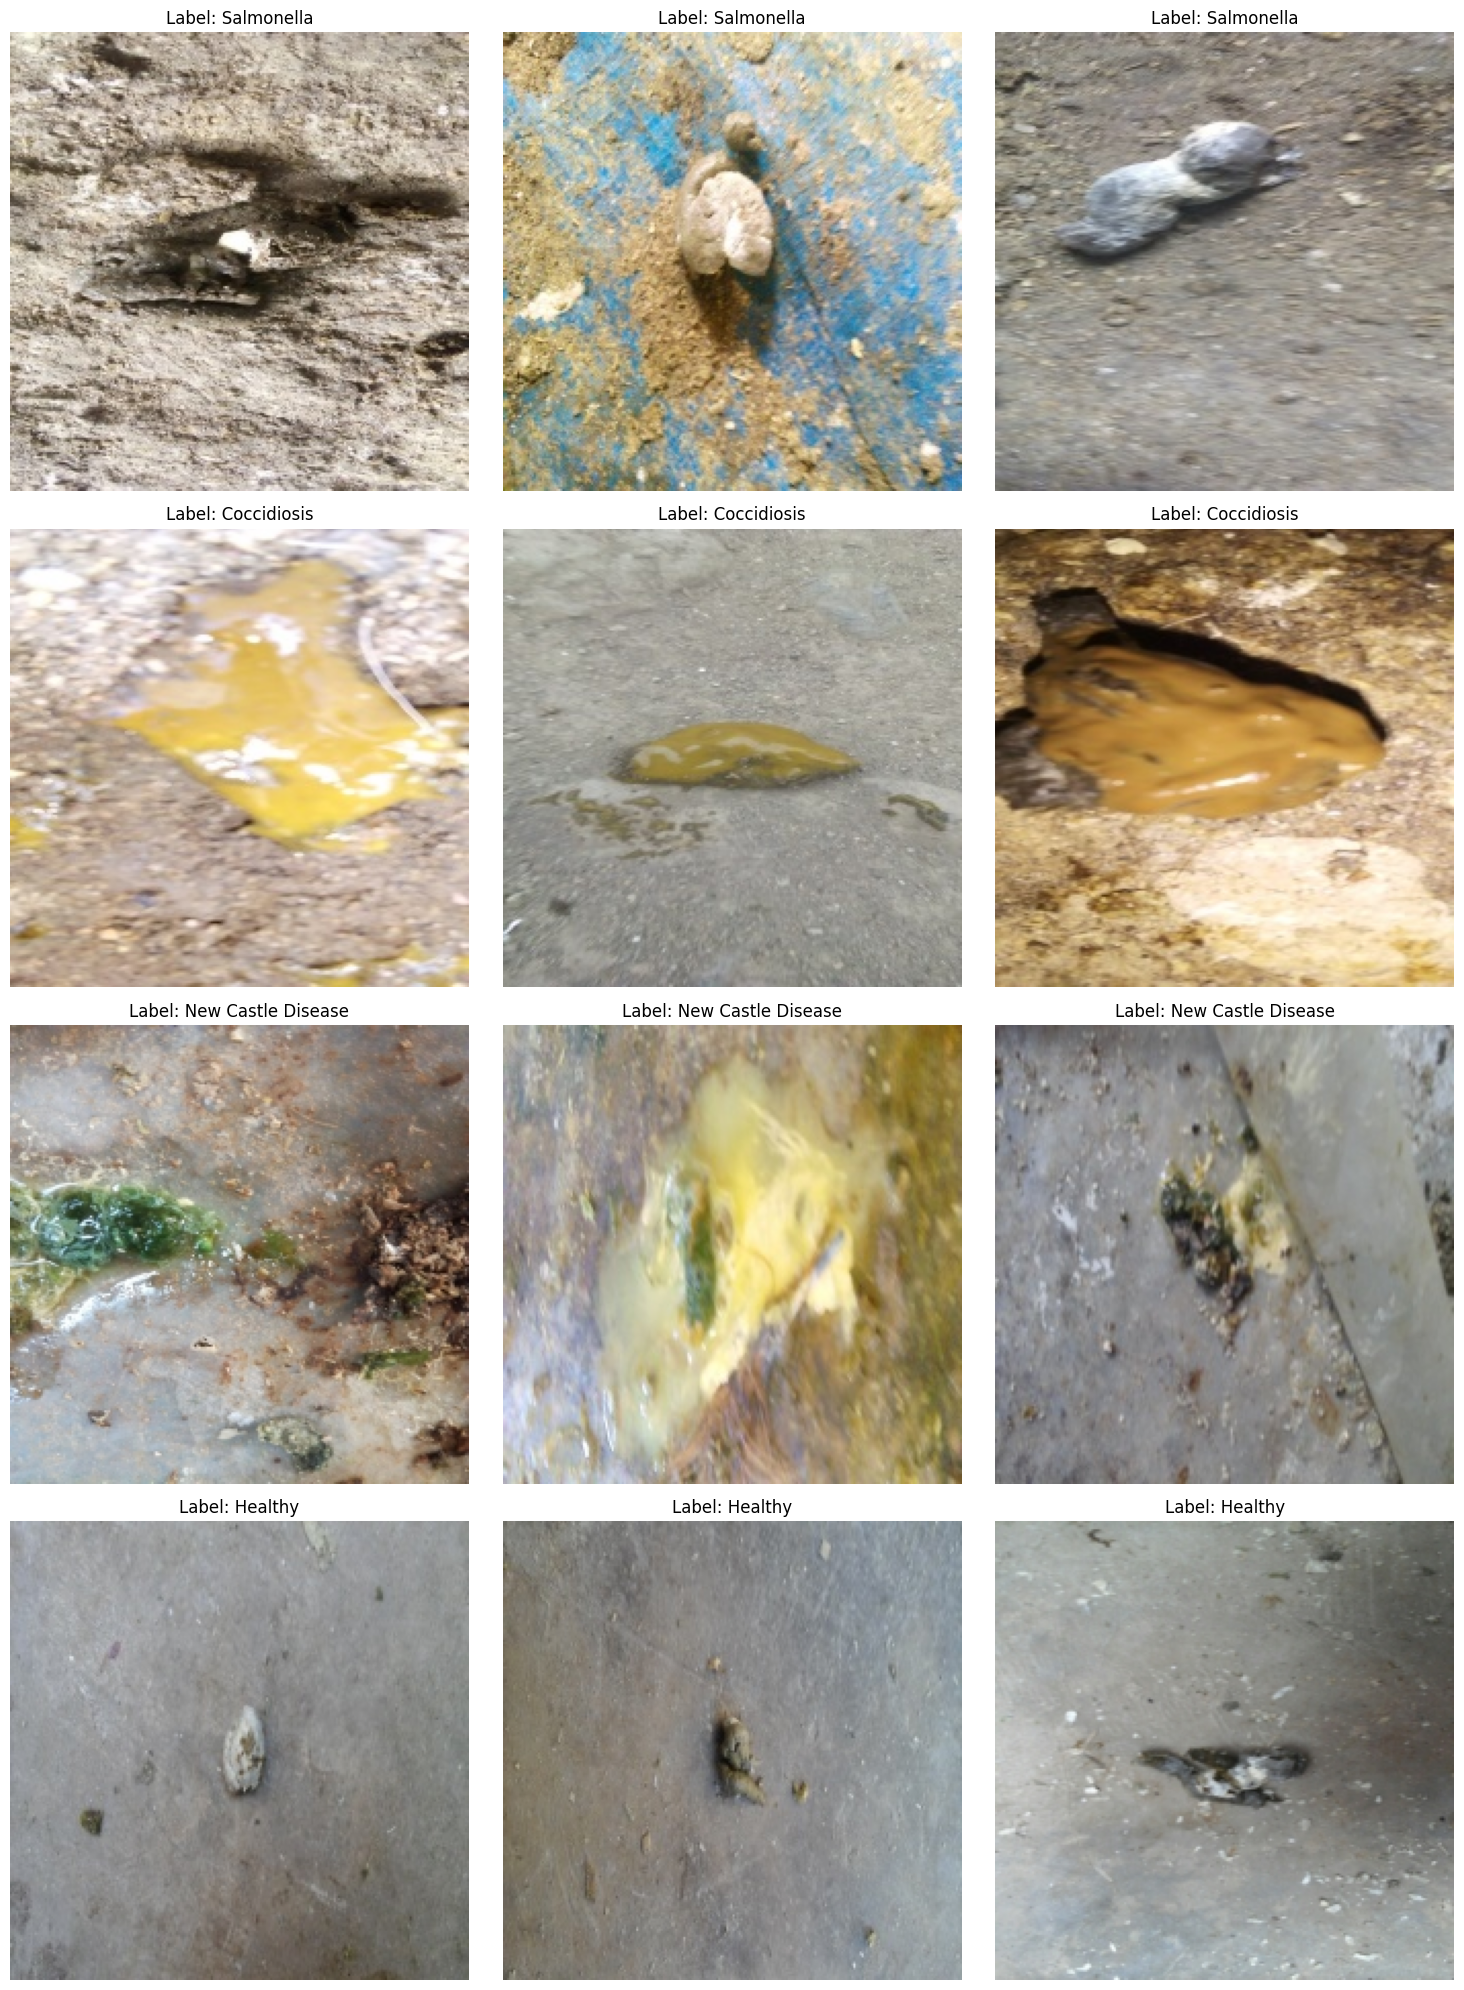

In [8]:
# Function to display sample images from each class
def display_sample_images(df, num_samples=3):
    classes = df['label'].unique()
    plt.figure(figsize=(15, 5 * len(classes)))
    
    for i, label in enumerate(classes):
        # Get samples for this class
        class_samples = df[df['label'] == label].sample(num_samples, random_state=42)
        
        for j, (_, row) in enumerate(class_samples.iterrows()):
            img_path = os.path.join(base_path, row['images'])
            img = Image.open(img_path)
            
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(f"Label: {label}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display 3 samples per class
display_sample_images(df, num_samples=3)

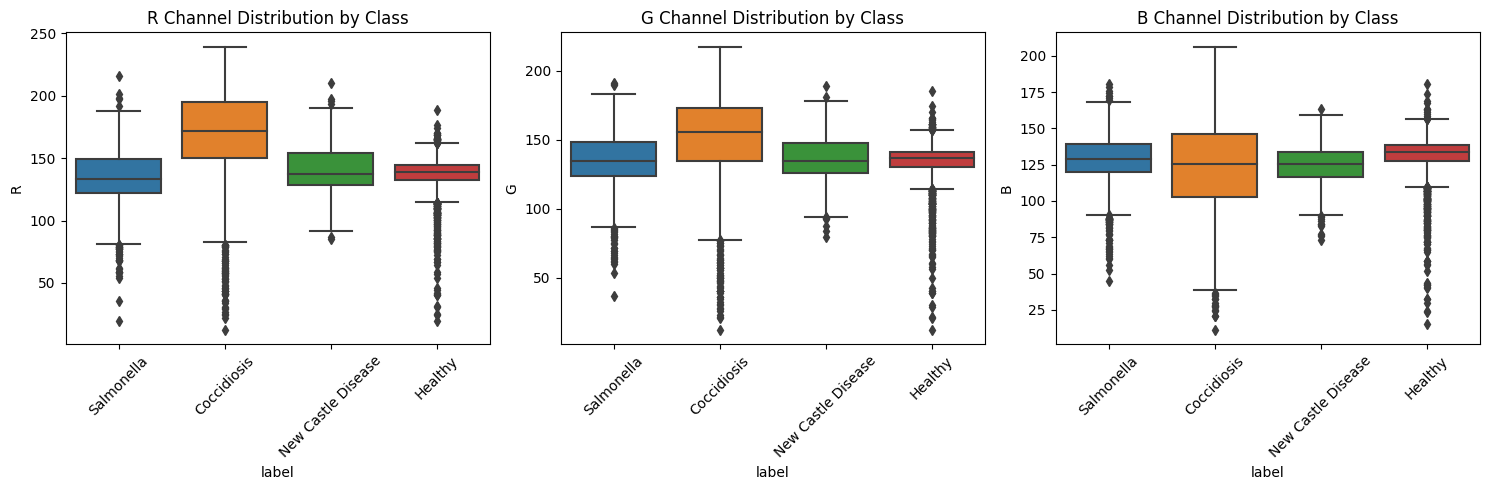

In [9]:
# Function to compute average RGB values for an image
def get_avg_rgb(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    avg_rgb = img.mean(axis=(0, 1))  # Mean across height and width
    return avg_rgb

# Compute average RGB for each image
rgb_values = []
labels = []

for _, row in df.iterrows():
    img_path = os.path.join(base_path, row['images'])
    try:
        avg_rgb = get_avg_rgb(img_path)
        rgb_values.append(avg_rgb)
        labels.append(row['label'])
    except Exception as e:
        print(f"Error processing {row['images']}: {e}")

# Create a DataFrame with RGB values
rgb_df = pd.DataFrame(rgb_values, columns=['R', 'G', 'B'])
rgb_df['label'] = labels

# Visualize RGB distribution by class
plt.figure(figsize=(15, 5))
for i, channel in enumerate(['R', 'G', 'B']):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(x='label', y=channel, data=rgb_df)
    plt.title(f"{channel} Channel Distribution by Class")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

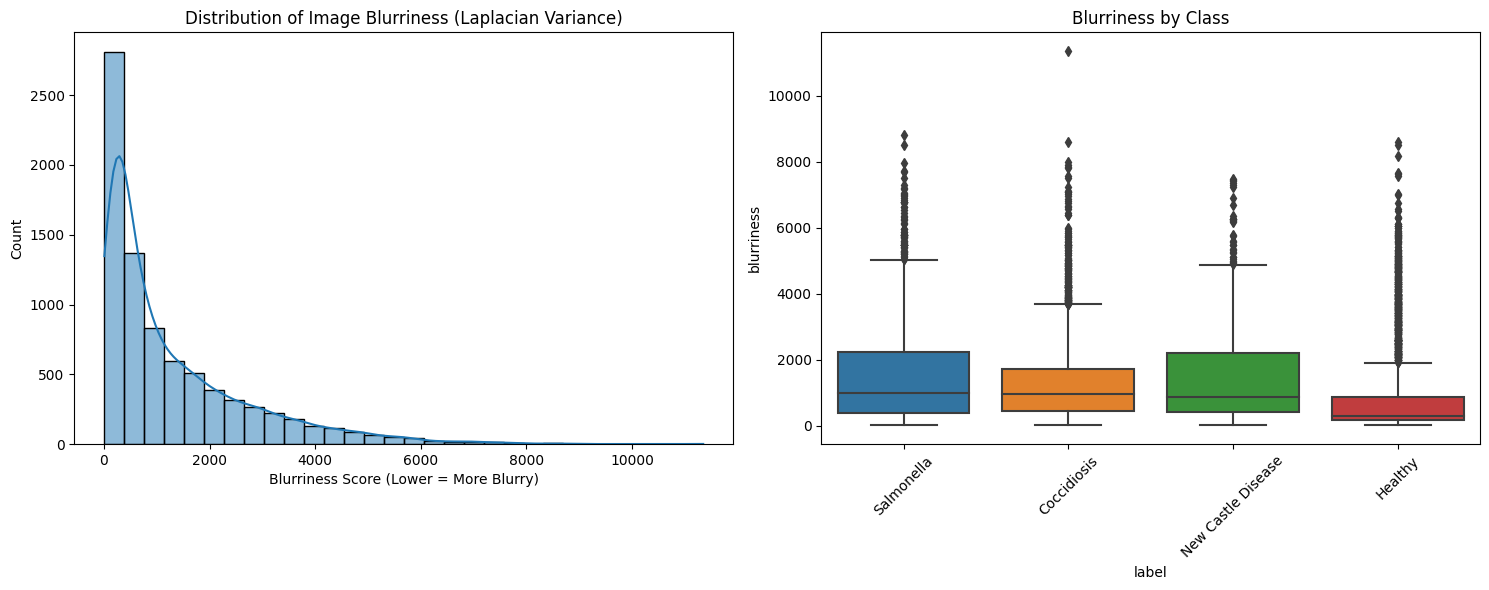

In [17]:
# Function to compute image blurriness using Laplacian variance
def compute_blurriness(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
    return laplacian_var

# Compute blurriness for each image
blurriness = []
for img_name in df['images']:
    img_path = os.path.join(base_path, img_name)
    try:
        blur_score = compute_blurriness(img_path)
        blurriness.append(blur_score)
    except:
        blurriness.append(None)

# Add blurriness to DataFrame
df['blurriness'] = blurriness

# Visualize blurriness distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Blurriness distribution (histogram)
sns.histplot(df['blurriness'].dropna(), bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Image Blurriness (Laplacian Variance)")
axes[0].set_xlabel("Blurriness Score (Lower = More Blurry)")

# Blurriness by class (boxplot)
sns.boxplot(x='label', y='blurriness', data=df, ax=axes[1])
axes[1].set_title("Blurriness by Class")
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## EDA Summary

- **Dataset Size:** 806 images with labels (Coccidiosis, Salmonella, Healthy, New Castle Disease).
- **Class Distribution:** Imbalanced—~300 Coccidiosis, ~300 Salmonella, ~150 Healthy, ~56 New Castle Disease. Will need to address imbalance (e.g., class weighting).
- **Image Sizes:** Most images are 224x224, with minor variations. Will resize all to 224x224 for consistency.
- **Image Quality:** Many images are blurry (Laplacian variance < 1000). Coccidiosis images are slightly sharper (median ~600–700), while Healthy images are blurrier (median ~400). Outliers exist in all classes, with some images having high sharpness (up to 10,000). May filter images with blurriness < 500 or apply sharpening.
- **Color Distribution:** [Fill in based on your previous step, e.g., "Coccidiosis images tend to have higher R values (possibly due to blood), while Salmonella images have higher G values (greenish tint). This could be a useful feature."]
- **Visual Patterns:** [Fill in based on your previous step, e.g., "Coccidiosis shows darker/bloody feces, Salmonella shows greenish tint, Healthy is more uniform. Backgrounds vary, may need segmentation."]

Number of images before filtering: 8067
Number of images after filtering (blurriness >= 500): 4737

Class Distribution After Filtering:
Salmonella            1790
Coccidiosis           1776
Healthy                785
New Castle Disease     386
Name: label, dtype: int64


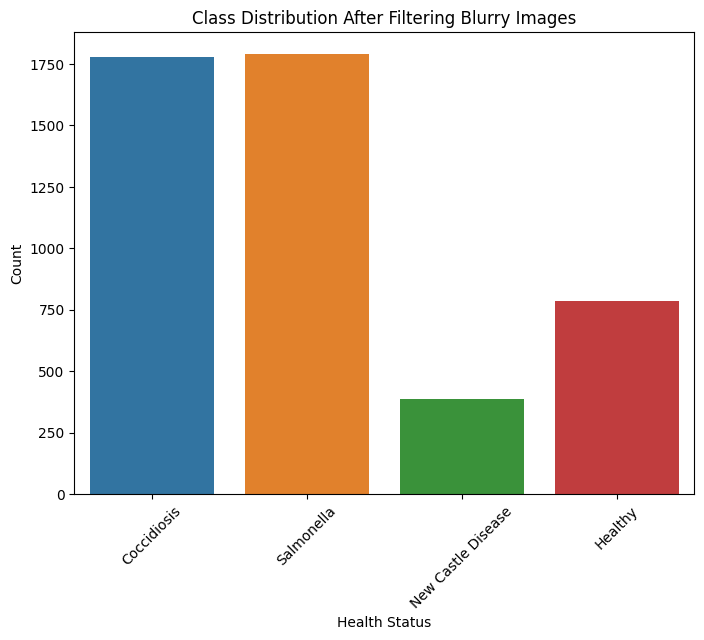

In [18]:
# Filter out blurry images (Laplacian variance < 500)
blurriness_threshold = 500
print(f"Number of images before filtering: {len(df)}")
df_filtered = df[df['blurriness'] >= blurriness_threshold].copy()
print(f"Number of images after filtering (blurriness >= {blurriness_threshold}): {len(df_filtered)}")

# Check class distribution after filtering
print("\nClass Distribution After Filtering:")
print(df_filtered['label'].value_counts())

# Visualize class distribution after filtering
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df_filtered)
plt.title("Class Distribution After Filtering Blurry Images")
plt.xlabel("Health Status")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

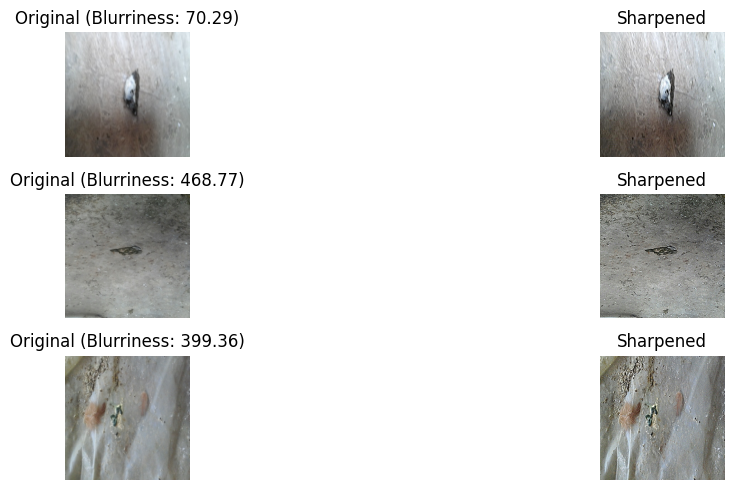

In [19]:
import cv2
import numpy as np

# Function to sharpen an image
def sharpen_image(img_path):
    img = cv2.imread(img_path)
    # Define a sharpening kernel
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    # Apply the sharpening filter
    sharpened = cv2.filter2D(img, -1, kernel)
    return sharpened

# Example: Sharpen a few blurry images and visualize
blurry_images = df[df['blurriness'] < 500].sample(3, random_state=42)
plt.figure(figsize=(15, 5))
for i, (_, row) in enumerate(blurry_images.iterrows()):
    img_path = os.path.join(base_path, row['images'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    sharpened = sharpen_image(img_path)
    sharpened = cv2.cvtColor(sharpened, cv2.COLOR_BGR2RGB)
    
    # Original image
    plt.subplot(3, 2, i*2 + 1)
    plt.imshow(img)
    plt.title(f"Original (Blurriness: {row['blurriness']:.2f})")
    plt.axis('off')
    
    # Sharpened image
    plt.subplot(3, 2, i*2 + 2)
    plt.imshow(sharpened)
    plt.title("Sharpened")
    plt.axis('off')

plt.tight_layout()
plt.show()